# Upwelling Scaling

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import gsw
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import viz_tools, utilities, places
from itertools import repeat, groupby
from scipy.signal import butter, lfilter, argrelextrema
from warnings import simplefilter

%matplotlib inline
plt.rcParams['font.size'] = 12
simplefilter("ignore")

***

## Scaling arguments

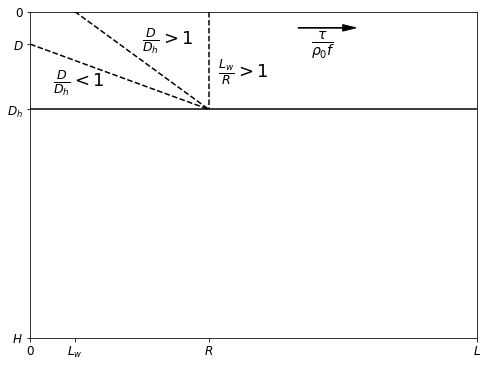

In [30]:
# Scaling diagram
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot([0, 1], [0.7, 0.7], 'k-')
ax.plot([0, 0.4], [0.9, 0.7], 'k--')
ax.plot([0.1, 0.4], [1, 0.7], 'k--')
ax.plot([0.4, 0.4], [1, 0.7], 'k--')
ax.xaxis.set_ticks([0, 0.1, 0.4, 1])
ax.xaxis.set_ticklabels([0, '$L_w$', '$R$', '$L$'])
ax.yaxis.set_ticks([0, 0.7, 0.9, 1])
ax.yaxis.set_ticklabels(['$H$', '$D_h$', '$D$', 0])
ax.arrow(0.6, 0.95, 0.1, 0, head_width=0.02, color='k')
ax.text(0.63, 0.89, '$\\frac{\\tau}{\\rho_0f}$', size=20)
ax.text(0.05, 0.77, '$\\frac{D}{D_h} < 1$', size=18)
ax.text(0.25, 0.9, '$\\frac{D}{D_h} > 1$', size=18)
ax.text(0.42, 0.8, '$\\frac{L_w}{R} > 1$', size=18)
plt.show()

Conservation of mass (Ekman flux over time equals pycnocline displacement)

### Pycnocline shoaling

When $D/D_h < 1$

$$\frac{DR}{2} = \frac{\tau T}{\rho_0f}$$

where

$$R = \frac{1}{f}\left(\frac{g'D_h(H - D_h)}{H}\right)^{\frac{1}{2}}$$

Thus

$$\boxed{\hspace{0.5cm}\frac{D}{D_h} = \frac{2\tau T}{\rho_0D_hfR}\hspace{0.5cm}} \tag{1}$$

### Advection of the halocline front

When $D/D_h = 1$

$$\frac{D_h\left(R + L_w\right)}{2} = \frac{\tau T}{\rho_0f}$$

Considering again R

$$\boxed{\hspace{0.5cm}\frac{L_w}{R} = \frac{2\tau T}{\rho_0D_hfR} - 1\hspace{0.5cm}} \tag{2}$$

When $L_w/R > 1$

$$L_wD_h = \frac{\tau T}{\rho_0f}$$

$$\boxed{\hspace{0.5cm}\frac{L_w}{R} = \frac{\tau T}{\rho_0D_hfR}\hspace{0.5cm}} \tag{3}$$

***
## Idealized runs
Define paths and load maskfile

In [136]:
# Define paths and load maskfile
path = '/data/bmoorema/results/Lake'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
maskfile = 'SalishSeaPond_S4d05ms_halocline10m_rhosurf1016/mesh_mask.nc'
mask = xr.open_dataset(os.path.join(path, maskfile)).isel(t=0)
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc').isel(y=slice(334, 898), x=slice(114, 398))

Plot transect locations

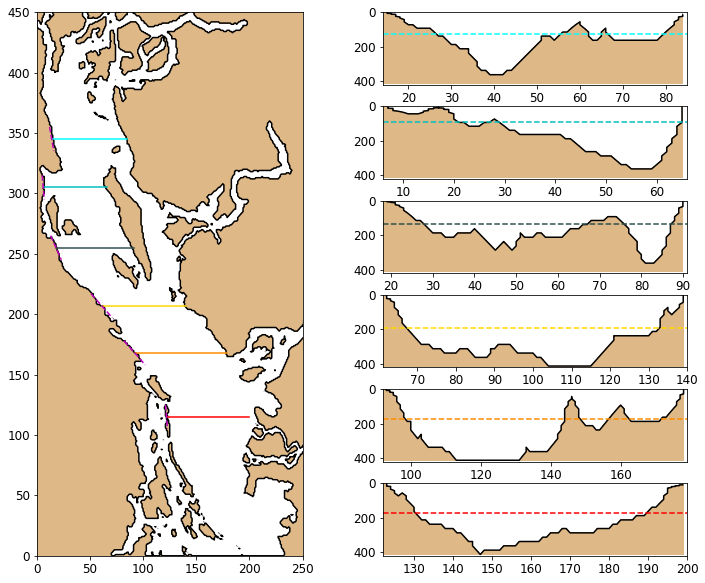

In [95]:
# Plot transect locations
fig = plt.figure(figsize=(12, 10))
gs = plt.GridSpec(6, 2, hspace=0.3)
ax = fig.add_subplot(gs[:, 0])
ax.contourf(mask.x, mask.y, mask.tmask[0, ...], levels=[-0.01, 0.01], colors='Burlywood')
ax.contour(mask.x, mask.y, mask.tmask[0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([0, 250])
ax.set_ylim([0, 450])
viz_tools.set_aspect(ax)
X = [[122, 200], [92, 179], [61, 140], [18, 91], [6, 66], [14, 85]]
Y = [115, 168, 207, 255, 305, 345]
slope = [10, 1, 1, 2, 10, 5]
H = []
colors = ['r', 'darkorange', 'gold', 'darkslategray', 'c', 'cyan']
for row, x, y, s, color in zip(range(6), X, Y, slope, colors):
    sec = fig.add_subplot(gs[5-row, 1])
    ax.plot(x, [y, y], '-', color=color)
    ax.plot([x[0]-10/s, x[0]+10/s], [y+10, y-10], 'm--')
    sec.contourf(mask.x[slice(*x)], mask.gdept_1d, mask.tmask[:, y, slice(*x)], levels=[-0.01, 0.01], colors='Burlywood')
    c = sec.contour(mask.x[slice(*x)], mask.gdept_1d, mask.tmask[:, y, slice(*x)], levels=[-0.01, 0.01], colors='k')
    H.append(c.collections[0].get_paths()[0].vertices[:, 1].mean())
    sec.plot(x, [H[-1], H[-1]], '--', color=color)
    sec.set_xlim(x)
    sec.set_ylim([420, 0])

Apply scaling analysis

In [175]:
# Define scaling parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200}
deptht = np.expand_dims(mask.gdept_1d, axis=1)
keys = ['vosaline', 'votemper']
hours = [12, 24, 48]
R = [0, 0, 0, 0, 0, 0]
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'D_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

In [187]:
def plot_scaling(correct_R=False, correct_Lw=True, correct_tau=False):
    """
    """

    # Make figure layout
    fig, axs = plt.subplots(2, 3, figsize=(17, 10))
    xlabel = '$\\frac{\\tau T}{\\rho D_hfR}$'
    ylabels = ['$D/D_h$', '$L_w/R$']
    for i, row, ylabel in zip(range(2), axs, ylabels):
        for ax, hour in zip(row, hours):
            ax.set_xlim([0, 8])
            ax.set_ylim([0, 5])
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            if i == 0:
                ax.plot([0, 0.5], [0, 1], 'k--')
                ax.plot([0.5, 8], [1, 1], 'k--')
                ax.set_title(f'{hour} hours')
            else:
                ax.plot([1, 3.5], [0, 5], 'm--')
                ax.plot([0.5, 5.5], [0, 5], 'k--')

    # Load runs and apply scaling
    bar = utilities.statusbar('Loading ...')
    for D_c in bar(param['D_h']):
        for rho_s in param['rho_surf']:
            g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
            R = list(repeat(np.sqrt(g_prime * D_c * (const['H'] - D_c) / const['H']) / const['f'], 6))
            # ----------------------------------------------------------------------------------------
            # Correct R for bathymetry
            if correct_R:
                for i, x, y, s in zip(range(6), X, Y, slope):
                    H, H_old = const['H'], 0
                    while abs(H - H_old) > 10:
                        H_old = H
                        H = int(bathy.Bathymetry[y, slice(x[0], x[0] + int(R[i] / np.sin(np.arctan(s)) / 440))].mean())
                        R[i] = np.sqrt(g_prime * D_c * (H - D_c) / H) / const['f']
            # ----------------------------------------------------------------------------------------
            for U, tau in zip(param['u_wind'], param['tau']):
                runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{D_c:2d}m_rhosurf{rho_s:4d}'
                with xr.open_dataset(os.path.join(path, runID, fn)) as data:
                    for x, y, s, r, color in zip(X, Y, slope, R, colors):
                        # ----------------------------------------------------------------------------
                        # Correct for transect angle
                        coeff_Lw = 1
                        if correct_Lw:
                            coeff_Lw = np.sin(np.arctan(s))

                        # Correct for wind angle
                        coeff_tau = 1
                        if correct_tau:
                            coeff_tau = np.cos(np.arctan(2) - np.arctan(s))
                        # ----------------------------------------------------------------------------
                        D_calc = coeff_tau * tau * 3600 / (const['rho_0'] * D_c * const['f'] * r)
                        loc = (0, slice(None), y, slice(*x))
                        rho_t0 = gsw.rho(*[np.ma.masked_where(mask.tmask[loc[1:]] == 0, data[k][loc]) for k in keys], deptht)
                        rho_halo = np.median(rho_t0[abs(deptht[:, 0] - D_c).argmin(), :])
                        for col, hour in zip(axs.T, hours):
                            T = hour - 3
                            loc = (hour, 0, y, slice(*x))
                            rho = gsw.rho(*[np.ma.masked_where(mask.tmask[loc[1:]] == 0, data[k][loc]) for k in keys], 0)
                            L_w = coeff_Lw * (rho >= rho_halo).sum() * 440 / r
                            D_model = deptht[int(np.median(abs(rho_t0 - rho.max()).argmin(axis=0))), 0] / D_c
                            col[0].plot(T * D_calc, D_model, 'o', color=color, markeredgecolor='k')
                            col[1].plot(T * D_calc, L_w, 'o', color=color, markeredgecolor='k')

### No corrections

Loading ... 100% (3 of 3) |####################################################################|Time: 0:01:09


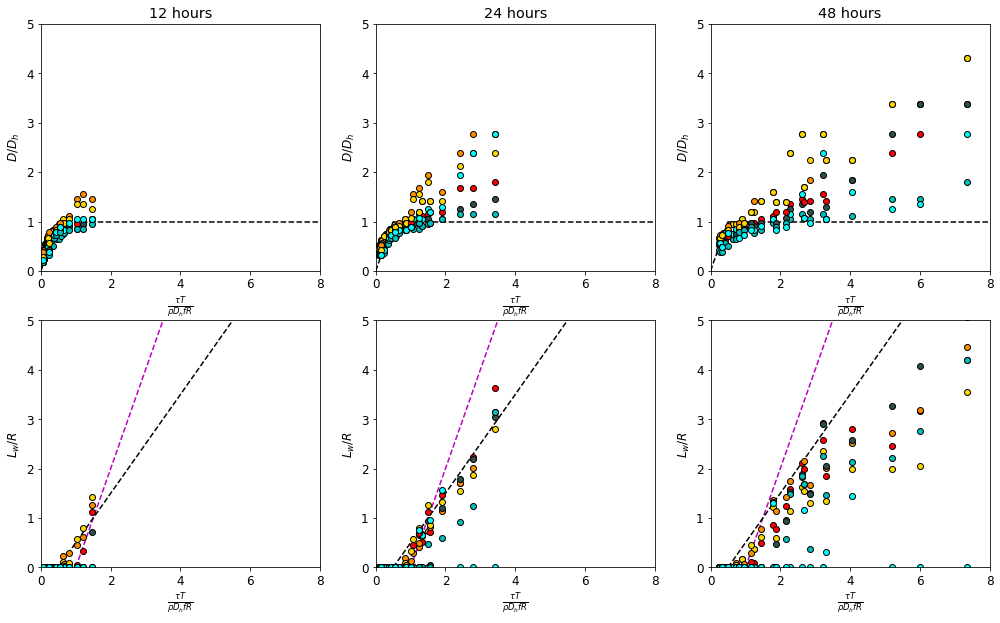

In [188]:
plot_scaling()

### Recalculate R using transect bathymetry

Loading ... 100% (3 of 3) |####################################################################|Time: 0:01:09


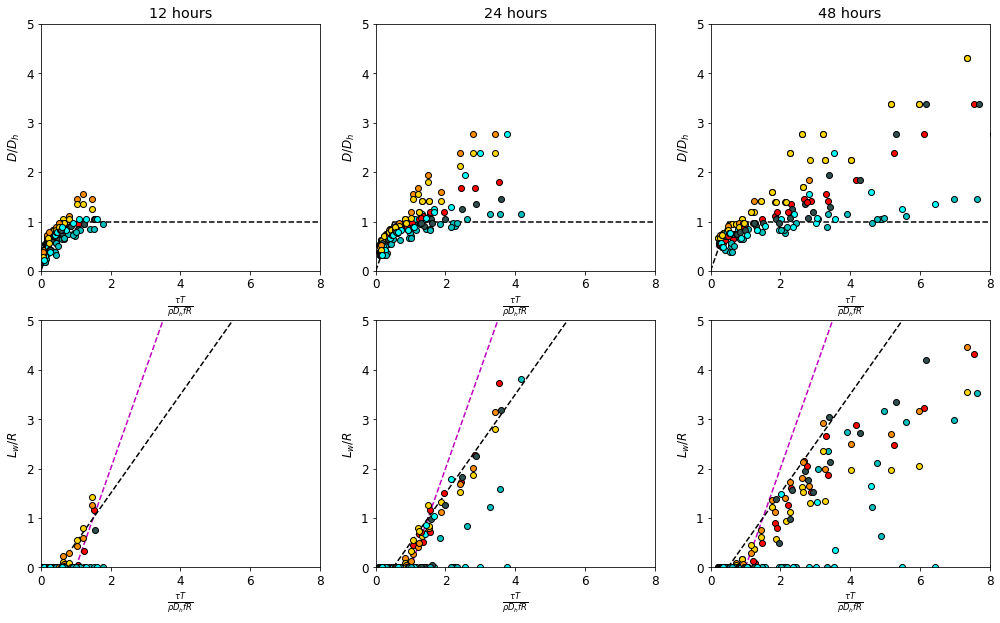

In [189]:
plot_scaling(correct_R=True)

### Correct for coastline angle to wind

Loading ... 100% (3 of 3) |####################################################################|Time: 0:01:08


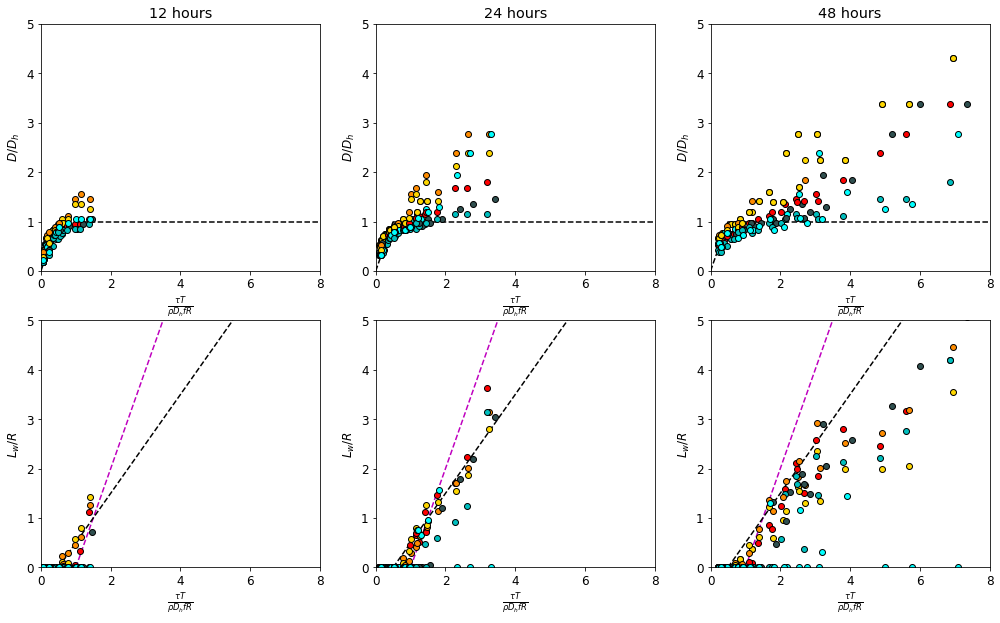

In [190]:
plot_scaling(correct_tau=True)

### Correct for R and coastline angle to wind

Loading ... 100% (3 of 3) |####################################################################|Time: 0:01:07


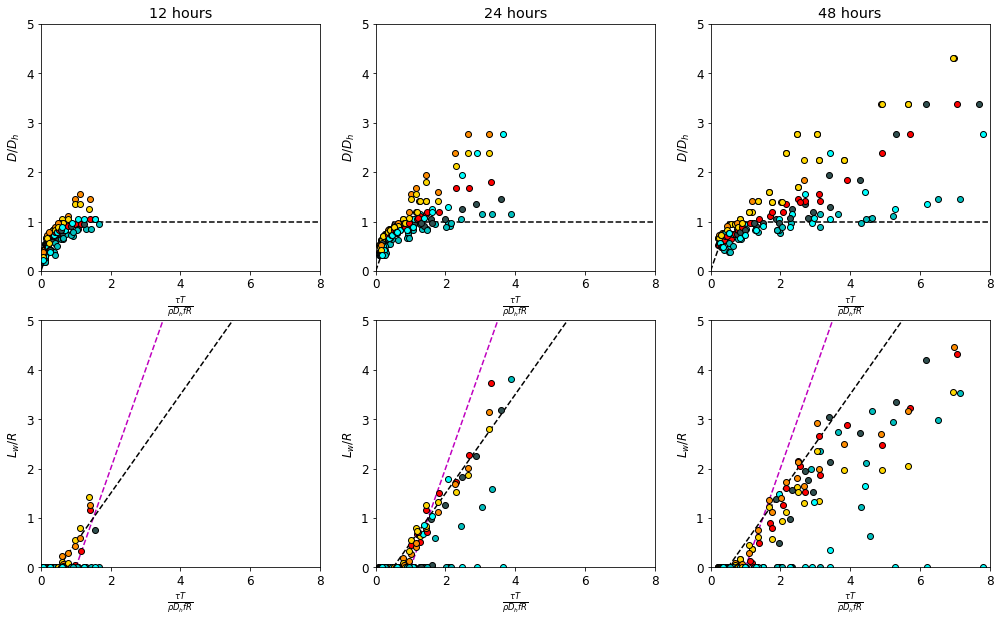

In [191]:
plot_scaling(correct_R=True, correct_tau=True)

***

## Hindcast record

Local function to make file path prefix

In [ ]:
def make_prefix(date, paths, res='h'):
    """
    """
    
    datestr = date.strftime('%Y%m%d')
    path = paths['loadpath']
    if paths['date_cutoff'] is not None:
        if date >= parse(paths['date_cutoff']):
            path = paths['loadpath_cutoff']
    fn = '_'.join(['SalishSea', f'1{res}', *repeat(datestr, 2), ''])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

Define netCDF objects and paths

In [ ]:
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc').isel(t=0)
paths = {
    'loadpath': '/results/SalishSea/hindcast.201812',
    'loadpath_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'savepath': '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast',
    'date_cutoff': '2016 Nov 21',
}

Define upwelling event start dates

In [ ]:
# Upwelling event date windows
events = [parse(date) for date in [
    '2015 Mar 11 08:00',
    '2015 Mar 19 00:00',
    '2015 Mar 25 01:00',
    '2015 Mar 28 22:00',
    '2015 Apr 26 08:00',
    '2016 Apr 11 20:00',
    '2017 Apr 04 06:00',
    '2017 May 31 00:00',
    '2017 Sep 09 08:00',
    '2017 Sep 17 06:00',
    '2017 Oct 21 06:00',
    '2018 Mar 23 00:00',
    '2018 Apr 04 01:00',
    '2018 Apr 13 00:00',
    '2018 Sep 07 14:00',
    '2018 Sep 15 00:00',
    '2018 Oct 23 12:00',
]]

Extract results

In [ ]:
keys = ['vosaline', 'votemper']
xlim = [169, 242]
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
loc = (slice(None), 547, slice(*xlim))
deptht = np.expand_dims(mask.gdept_1d.values, axis=1)
Q = {}

fig, axs = plt.subplots(17, 3, figsize=(17, 40))

bar = utilities.statusbar('Loading ...')
for row, event in zip(axs, bar(events)):
    tag = event.strftime('%Y%m%d')
    Q[tag] = {'tau': {}, 'depth': {}}
    for hour in [0, 8]:
        date = event + timedelta(hours=hour)
        with xr.open_dataset(make_prefix(date, paths) + 'grid_T.nc').sel(time_counter=date, method='nearest') as T, \
             xr.open_dataset(make_prefix(date, paths) + 'grid_V.nc').sel(time_counter=date, method='nearest') as V:
            if hour == 0:
                rho_0 = gsw.rho(*[np.ma.masked_where(mask.tmask[loc] == 0, T[k][loc]) for k in keys], deptht)
                N2 = 9.81 * np.diff(rho_0, axis=0) / (1024 * deptht[1:, :])
                v = np.ma.masked_where(mask.tmask[loc] == 0, V.vomecrty[loc])
                ihalocline = int(np.percentile(N2.argmax(axis=0), 90)) + 1
                Q[tag]['N2'] = np.median(N2.max(axis=0).compressed())
                Q[tag]['halocline'] = deptht[ihalocline, 0]
                Q[tag]['rho'] = np.median(rho_0[:ihalocline, :].compressed())
                
                levels = [[1016, 1024, 0.1], [1e-5, 1e-3, 1e-5], [-0.5, 0.51, 0.01]]
                for ax, var, idepth, cmap, level in zip(
                    row, [rho_0, N2, v], [0, 1, 0], ['dense', 'amp', 'curl'], levels,
                ):
                    ax.contourf(
                        T.x[slice(*xlim)], deptht[idepth:, 0], var,
                        levels=np.arange(*level), cmap=getattr(cm, cmap), extend='both',
                    )
                    ax.set_xlim(xlim)
                    ax.set_ylim([30, 0])
                row[1].plot(xlim, [Q[tag]['halocline'], Q[tag]['halocline']], 'w--')
            else:
                Q[tag]['tau'][hour] = sum(1.225e-3 * HRDPS.v_wind.sel(time=slice(event, date))[:, j, i].values**2) * 3600
                rho = gsw.rho(*[np.ma.masked_where(mask.tmask[loc] == 0, T[k][loc]) for k in keys], deptht)
                rho_max = np.percentile(rho[0, :].compressed(), 90)
                Q[tag]['depth'][hour] = deptht[int(np.percentile(abs(rho_0 - rho_max).argmin(axis=0), 50)), 0]
                
                for var in [rho_0, rho]:
                    row[0].contour(T.x[slice(*xlim)], deptht[:, 0], var, levels=[rho_max], colors='w')
                row[0].plot(xlim, [Q[tag]['depth'][hour], Q[tag]['depth'][hour]], 'w--')